# Final Project Code

Jupiter Angulo
02.26.23

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import os
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from vit_keras import vit, utils, visualize
from torch.utils.data import DataLoader
import tensorflow_addons as tfa

In [3]:
df = "dataset/train"

df_labels = pd.read_csv('dataset/train.csv')

In [15]:
img_shape = (224, 224)
batch_size = 32


datagen = ImageDataGenerator(rescale=1/255., 
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip =True)

print('Training Images:')

df_data_res = datagen.flow_from_dataframe(dataframe=df_labels,
                                         directory = df,
                                         x_col='image_ID',
                                         y_col='label',
                                         target_size=img_shape,
                                         batch_size=batch_size,
                                         class_mode=None)

Training Images:
Found 8227 validated image filenames.


In [142]:
df_labels['label'].value_counts()

Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: label, dtype: int64

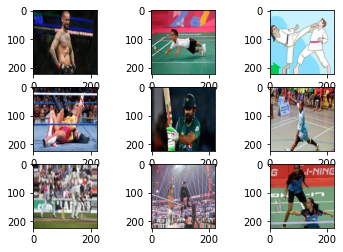

In [25]:
X = next(df_data_res) 

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i, :, :, :])
    
plt.show()

In [96]:
df_data_res.image_shape

(224, 224, 3)

## Train Test Split

In [16]:
validation_split = 0.8
train_split = 0.75
idxs = np.random.permutation(range(len(df_labels)))

train_idxs = idxs[:int(train_split * len(idxs))]
val_idxs = idxs[int(train_split * len(idxs)):int(validation_split * len(idxs))]
test_idxs = idxs[int(validation_split * len(idxs)):]

train_labels = df_labels.iloc[train_idxs]
val_labels = df_labels.iloc[val_idxs]
test_labels = df_labels.iloc[test_idxs]

print(len(train_labels), len(test_labels), len(val_labels))

6170 1646 411


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
# Augment the training generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.5,
    zoom_range = 0.5,
    rotation_range = 50,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

# Use consistent rescaling for validation and test generators
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)

In [19]:
# Set batch size and image shape
#batch_size = 32
#img_shape = (64, 64)

train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    directory = df,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)

test_generator = test_datagen.flow_from_dataframe(
    test_labels,
    directory = df,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)


validation_generator = validation_datagen.flow_from_dataframe(
    val_labels,
    directory = df,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)

Found 6170 validated image filenames belonging to 7 classes.
Found 1646 validated image filenames belonging to 7 classes.
Found 411 validated image filenames belonging to 7 classes.


## InceptionV3

In [11]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")



In [12]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [13]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 128)               6553728   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 28,373,927
Trainable params: 6,571,335
Non

In [25]:

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]



mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [105]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)

In [106]:
%time
history=model.fit(train_generator,validation_data=validation_generator,epochs = 10,verbose = 1,callbacks=[mcp,es])

Wall time: 0 ns
Epoch 1/10
193/193 [==============================] - 311s 2s/step - loss: 2.0130 - accuracy: 0.5982 - precision: 0.6330 - recall: 0.5686 - auc: 0.8700 - val_loss: 0.9372 - val_accuracy: 0.6959 - val_precision: 0.7161 - val_recall: 0.6691 - val_auc: 0.9364
Epoch 2/10
193/193 [==============================] - 238s 1s/step - loss: 0.7914 - accuracy: 0.7417 - precision: 0.7737 - recall: 0.7063 - auc: 0.9507 - val_loss: 0.6896 - val_accuracy: 0.7737 - val_precision: 0.8041 - val_recall: 0.7689 - val_auc: 0.9604
Epoch 3/10
193/193 [==============================] - 259s 1s/step - loss: 0.6954 - accuracy: 0.7627 - precision: 0.8038 - recall: 0.7303 - auc: 0.9601 - val_loss: 0.5981 - val_accuracy: 0.7883 - val_precision: 0.8194 - val_recall: 0.7616 - val_auc: 0.9696
Epoch 4/10
193/193 [==============================] - 267s 1s/step - loss: 0.6838 - accuracy: 0.7677 - precision: 0.8071 - recall: 0.7376 - auc: 0.9609 - val_loss: 0.5334 - val_accuracy: 0.8078 - val_precision: 0.

In [180]:
history.model.evaluate(test_generator)

44/52 [========================>.....] - ETA: 11s - loss: 0.3952 - accuracy: 0.8615 - precision: 0.8768 - recall: 0.8438 - auc: 0.9851Collecting transformers
     ---------------------------------------- 6.3/6.3 MB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 5.5 MB/s eta 0:00:00
     -------------------------------------- 190.3/190.3 kB 5.6 MB/s eta 0:00:00


52/52 [==============================] - 74s 1s/step - loss: 0.3783 - accuracy: 0.8663 - precision: 0.8816 - recall: 0.8505 - auc: 0.9864


[0.37827038764953613,
 0.8663426637649536,
 0.8816120624542236,
 0.8505467772483826,
 0.9863536953926086]

## Transfer Learning

In [269]:
vgg_base_model=keras.applications.VGG16(
weights="imagenet",   # Load weights pre-trained on ImageNet.
input_shape=(224,224,3),
include_top=False) # Do not include the ImageNet classifier at the top.

58889256/58889256 [==============================] - 4s 0us/step


In [270]:
for l in vgg_base_model.layers:
    print(l.name,l.trainable)

input_34 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [271]:
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [272]:
for l in vgg_base_model.layers[:-4]:
    l.trainable=False

In [273]:
for l in vgg_base_model.layers:
    print(l.name, l.trainable)

input_34 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [274]:
inputs=keras.Input(shape=(224,224,3))

x=vgg_base_model(inputs)
# Convert the features of shape base_model.output_shape[1:] to vectors
x=keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 7 unit (multiclass classification)
x=keras.layers.Dense(512,activation="relu")(x)
x=keras.layers.Dropout(0.3)(x)

outputs=keras.layers.Dense(7,activation="softmax")(x)
model=keras.Model(inputs,outputs)

In [275]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_52 (Dense)            (None, 512)               262656    
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_53 (Dense)            (None, 7)                 3591      
                                                           

In [280]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('vgg_mdl_wts_0.0001.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_vgg=model.fit(train_generator,epochs=3,validation_data=validation_generator,callbacks=[earlyStopping, mcp_save]) 

Epoch 1/3
193/193 [==============================] - 4158s 22s/step - loss: 1.1136 - accuracy: 0.5940 - val_loss: 0.6871 - val_accuracy: 0.7883
Epoch 2/3
193/193 [==============================] - 4027s 21s/step - loss: 0.6667 - accuracy: 0.7682 - val_loss: 0.4842 - val_accuracy: 0.8589
Epoch 3/3
193/193 [==============================] - 4206s 22s/step - loss: 0.5205 - accuracy: 0.8152 - val_loss: 0.5187 - val_accuracy: 0.8297


In [281]:
history_vgg.model.evaluate(test_generator)

52/52 [==============================] - 987s 19s/step - loss: 0.4723 - accuracy: 0.8354


[0.47234615683555603, 0.8353584408760071]

In [282]:
history_vgg.model.save('vgg16_model_ja')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020A91876B80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020A91876B80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get 

INFO:tensorflow:Assets written to: vgg16_model_ja\assets


INFO:tensorflow:Assets written to: vgg16_model_ja\assets


In [283]:
model.save('vit_l32_model_ja')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020CE0C41DC0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020CE0C41DC0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020CE0C41DC0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: vit_l32_model_ja\assets


INFO:tensorflow:Assets written to: vit_l32_model_ja\assets


In [284]:
history.model.save('inceptionv3_model_ja')

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020A91876B80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020A91876B80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x0000020A91876B80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: inceptionv3_model_ja\assets


INFO:tensorflow:Assets written to: inceptionv3_model_ja\assets


ViT_l32

In [ ]:
image_size = 224
model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=7
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train the model using the data generators
model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=10
)

In [194]:
model.evaluate(test_generator)

##Accuracy is horrible going to try softmax

52/52 [==============================] - 321s 6s/step - loss: 1.2147 - accuracy: 0.5194


[1.214692234992981, 0.5194410681724548]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this

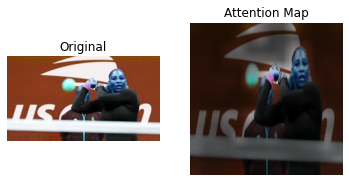

In [267]:
# Load a model
image_size = (224,224)
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
image = cv2.imread('dataset/train/00a87b6bb3.jpg')
img1 =  cv2.resize(image, (224,224)) 
attention_map = visualize.attention_map(model=model, image=img1)
print('Prediction:', classes[
    model.predict(vit.preprocess_inputs(img1)[np.newaxis])[0].argmax()]
) 

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [27]:
## Load Model

inception_model = tf.keras.models.load_model('inceptionv3_model_ja', compile=False)

In [28]:
inception_model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics=METRICS)

In [30]:
inception_model.evaluate(test_generator)

52/52 [==============================] - 34s 255ms/step - loss: 0.3426 - accuracy: 0.8840 - precision: 0.8987 - recall: 0.8682 - auc: 0.9881


[0.34264224767684937,
 0.8839611411094666,
 0.898742139339447,
 0.8681652545928955,
 0.9880970120429993]

In [34]:
inception_model

In [ ]:
# Get an image and compute the attention map
image = cv2.imread('dataset/test/0ba0fe4b6a.jpg')

img1 = cv2.resize(image, (224, 224))
#image = np.expand_dims(image, axis=0)
#image = image / 255.0  # normalize pixel values to [0, 1]

model = vit.vit_l32(
    image_size=224,
    activation='sigmoid',
    pretrained_top=False,
    include_top=True,
    pretrained=True,
)

# Load the Keras model
model.load_weights('vit_l32_model_ja')



# Get the attention map
attention_map = visualize.attention_map(model, img1)

# Display the attention map
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img1)
_ = ax2.imshow(attention_map)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

D:\Analytics\anaconda\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


1/1 [==============================] - 7s 7s/step


In [18]:
print(model.layers[5].output_shape)

(None, 7)
